## Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import string, re
import gc # garbage collector to manage RAM usage
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

In [34]:
tweets = pd.read_csv('train 2.csv')
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [35]:
# Rename columns to avoid clashes with the words in vocab later
tweets.rename(columns={'label':'Label', 'tweet':'Tweet'}, inplace=True)

# Drop column 'id'
tweets.drop(columns='id', inplace=True)

# Check distribution of class of tweets
tweets.Label.value_counts()

0    29720
1     2242
Name: Label, dtype: int64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(tweets['Tweet'], tweets['Label'], test_size=0.2, 
                                                    stratify=tweets['Label'], random_state=1)

# Combine the results into train and test dataframe
tweets_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
tweets_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(f'the number of training data is {len(tweets_train)}')
print(f'the number of test data is {len(tweets_test)}')
tweets_train.head()

the number of training data is 25569
the number of test data is 6393


,Tweet,Label
0,this is chess #mlittle801 #breezeslc #fitness ...,0
1,@user @user @user @user @user i bet thats wh...,0
2,happiness is @user so find your happiness tod...,0
3,@user &lt;3 &lt;3 listen to my most beautiful ...,0
4,free @user !! #jesuismilo !!,0


## Data Preprocessing

In [37]:
def clean_tweet(tweet):
    """
    Tokenize tweets into words. Convert texts to lower case.
    Remove hashtags, punctuations, stopwords, website links, extra spaces, non-alphanumeric characters and 
    single character. Lemmatize texts.
    """

    twt_tokenizer = TweetTokenizer(strip_handles=True) # remove username handles
    tokens = [token for token in twt_tokenizer.tokenize(tweet)]
    
    # Combine stopwords and punctuation
    stops = stopwords.words("english") + list(string.punctuation)

    # special characters
    s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
    
    # Create lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
    tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
    tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
    tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
    tokens_no_special_char = [re.sub(r'[{}]'.format(s_chars), '', token) for token in tokens_no_url]
    tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_special_char]
    tokens_alnum = [token for token in tokens_no_extra_space if token.isalnum()]
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_alnum]
    tokens_final = [token for token in tokens_lemma if len(token) > 1]
    
    return tokens_final

In [38]:
tweets_train['Tweet'] = tweets_train['Tweet'].apply(clean_tweet)
tweets_train.head()

,Tweet,Label
0,"[chess, mlittle801, breezeslc, fitness, nofilt...",0
1,"[bet, thats, left, feeding, think, actually, b...",0
2,"[happiness, find, happiness, today, happiness,...",0
3,"[listen, beautiful, best, friend, singing, ama...",0
4,"[free, jesuismilo]",0


In [39]:
vocab = []

for index, value in tweets_train['Tweet'].items():
    for word in value:
        vocab.append(word)
        
# Transform vocab from list to set to remove duplicate words
vocab = list(set(vocab))

print("Number of vocabularies in the training set is {}".format(len(vocab)))

Number of vocabularies in the training set is 31426


In [40]:
# Combine all the tweets into a single list
corpus = tweets_train['Tweet'].apply(lambda x:' '.join(x))

# Fit CountVectorizer
vectorizer = CountVectorizer()
X_train_wc = vectorizer.fit_transform(corpus)
X_train_wc

<25569x31426 sparse matrix of type '<class 'numpy.int64'>'
	with 184788 stored elements in Compressed Sparse Row format>

In [41]:
vocab_counts = pd.DataFrame(X_train_wc.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate vocab_counts with the original tweets_train dataframe
tweets_train = pd.concat([tweets_train, vocab_counts], axis=1)
tweets_train.head()

,Tweet,Label,000,001,003junior,00h30,01,0161,019,01926889917,...,ªvotetrump,ªã,µgod,µã,ºit,ºsoffierose,ºthat,ºwhy,ºº,ºã
0,"[chess, mlittle801, breezeslc, fitness, nofilt...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[bet, thats, left, feeding, think, actually, b...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[happiness, find, happiness, today, happiness,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[listen, beautiful, best, friend, singing, ama...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[free, jesuismilo]",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Convert y_train and y_test to array
y_train = np.array(tweets_train['Label'])
y_test = np.array(tweets_test['Label'])

# Create X_test_wc using sklearn CountVectorizer
corpus = tweets_test['Tweet'].apply(clean_tweet).apply(lambda x:' '.join(x))
X_test_wc = vectorizer.transform(corpus)

# Ensure the shape of X, y in training and test set is correct
print("Shape of X_train: {}".format(X_train_wc.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test_wc.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (25569, 31426)
Shape of y_train: (25569,)
Shape of X_test: (6393, 31426)
Shape of y_test: (6393,)


In [43]:
clf = MultinomialNB() 
clf.fit(X_train_wc, y_train)
clf.score(X_test_wc, y_test)

0.9596433599249179

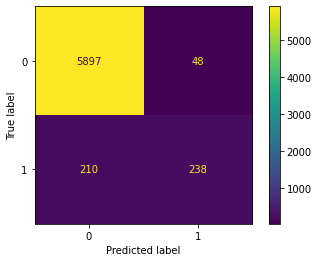

In [44]:
# Generate confusion matrix plot
y_pred = clf.predict(X_test_wc)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### Things to improve on
- Tune the hyperparameters
- Try using term frequency-inverse document frequency (tf-idf) instead of feature counts to represent the features. This will lower the weights of word that is similar across all the tweets.
- Consider methods that trim down the vocabularies (e.g., synonym finding, remove words with occurrence lower than a certain threshold, etc.). Currently, we have nearly 33,000 features and many of them might not be useful.